In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/training_dataset/new_queues_concurrency_4_after_migration/preprocessed_data.csv')

In [3]:
df.date = pd.to_datetime(df.date)

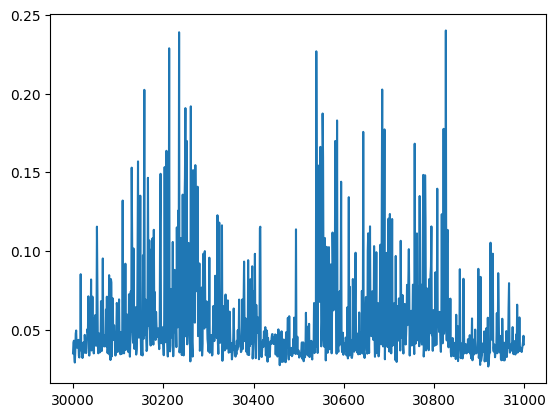

In [5]:
plt.plot(df.iloc[30000:31000].pipelines_status_realtime_pipeline_latency)

<Axes: >

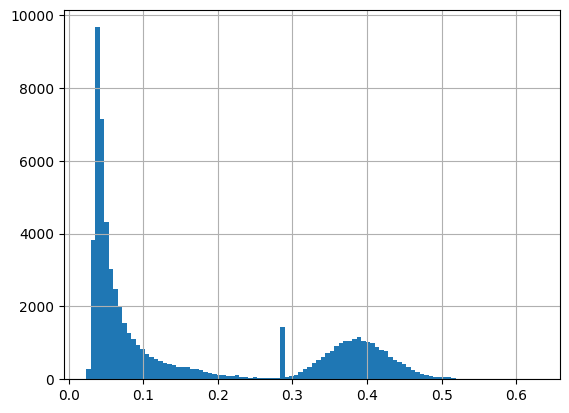

In [6]:
df.pipelines_status_realtime_pipeline_latency.hist(bins=100)

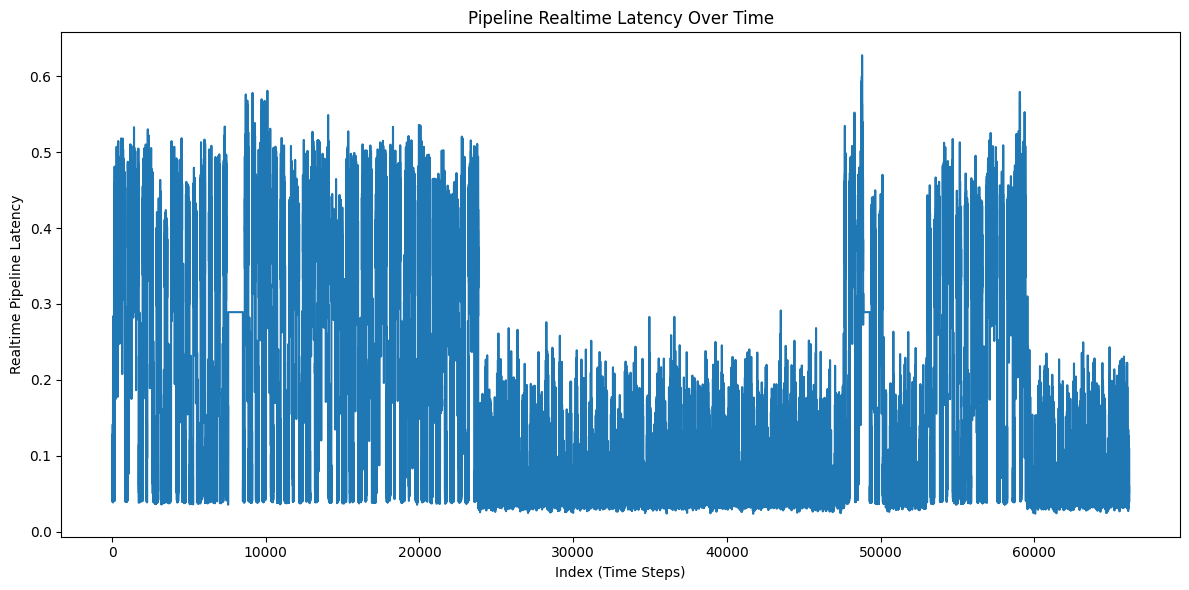

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['pipelines_status_realtime_pipeline_latency'])
plt.title('Pipeline Realtime Latency Over Time')
plt.xlabel('Index (Time Steps)')
plt.ylabel('Realtime Pipeline Latency')
plt.tight_layout()
plt.show()

In [8]:
# Vectorized approach (faster)
def create_transition_feature_vectorized(df, column='pipelines_status_realtime_pipeline_latency', 
                                       threshold=0.2, window=10):
    """
    Create binary feature that is 1 if there's a transition from under threshold 
    to above threshold in the next window rows.
    Vectorized version for better performance
    """
    series = df[column]
    result = []
    
    for i in range(len(series)):
        # Get next window
        end_idx = min(i + window + 1, len(series))
        window_data = series.iloc[i:end_idx]
        
        # Check for transition: create boolean masks
        under_threshold = window_data < threshold
        above_threshold = window_data >= threshold
        
        # Check if we have a transition from under to over
        has_transition = False
        for j in range(len(window_data) - 1):
            if under_threshold.iloc[j] and above_threshold.iloc[j + 1]:
                has_transition = True
                break
                
        result.append(1 if has_transition else 0)
    
    return result

# Apply the vectorized version
df['latency_spike_next_10'] = create_transition_feature_vectorized(df)

In [9]:
df.latency_spike_next_10.value_counts()

0    59350
1     6831
Name: latency_spike_next_10, dtype: int64

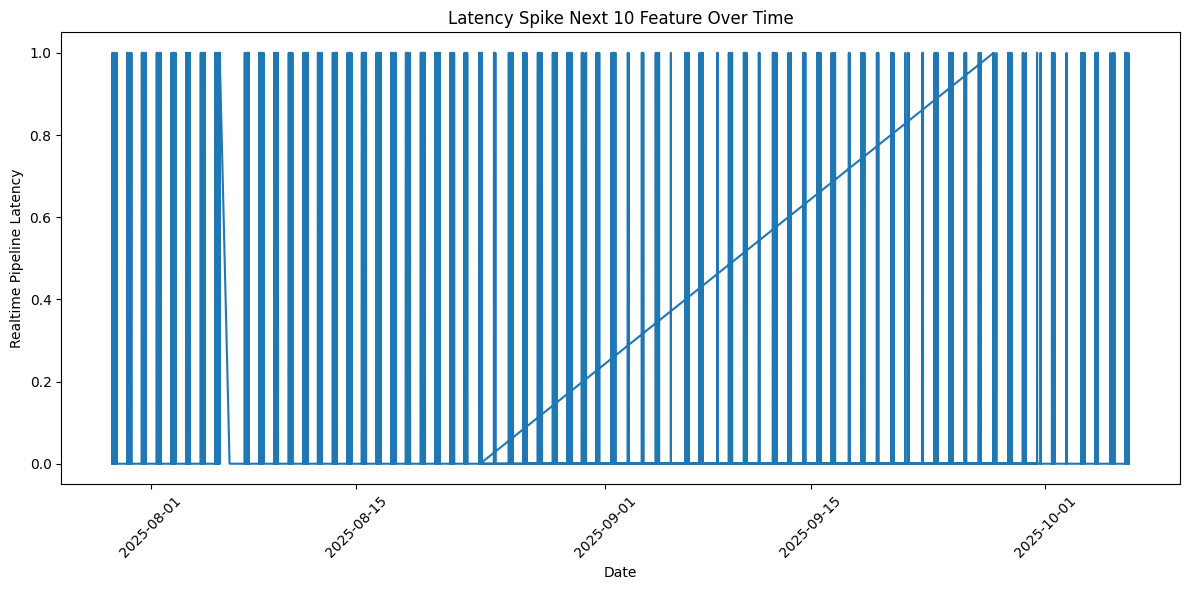

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['latency_spike_next_10'])
plt.title('Latency Spike Next 10 Feature Over Time')
plt.xlabel('Date')
plt.ylabel('Realtime Pipeline Latency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
def create_constant_values_feature(df, window_size=40, transition_col='latency_spike_next_10'):
    """
    Create binary feature that marks windows of constant values (no transitions) for deletion.
    Uses rolling windows and updates values when transitions are detected in subsequent windows.
    """
    n = len(df)
    constant_values_to_be_deleted = [0] * n  # Initialize all to 0
    
    # Step 1: Mark windows with no transitions as 1
    for i in range(n - window_size + 1):
        window_end = i + window_size
        window_transitions = df[transition_col].iloc[i:window_end]
        
        # If no transitions in this window, mark all rows in window as 1
        if window_transitions.sum() == 0:
            for j in range(i, window_end):
                constant_values_to_be_deleted[j] = 1

        # If current window has transitions, set all rows in this window to 0
        if window_transitions.sum() > 0:
            for j in range(i, window_end):
                constant_values_to_be_deleted[j] = 0
    
    
    # # Step 2: Update values to 0 if subsequent windows have transitions
    # for i in range(n - window_size + 1):
    #     window_end = i + window_size
        
    #     # Check if current window has transitions
    #     current_window_transitions = df[transition_col].iloc[i:window_end]
        
    #     # If current window has transitions, set all rows in this window to 0
    #     if current_window_transitions.sum() > 0:
    #         for j in range(i, window_end):
    #             constant_values_to_be_deleted[j] = 0
    
    return constant_values_to_be_deleted

# Apply the function
df['constant_values_to_be_deleted'] = create_constant_values_feature(df)

# Check the results
print(f"Total rows: {len(df)}")
print(f"Rows marked for deletion: {df['constant_values_to_be_deleted'].sum()}")
print(f"Rows to keep: {len(df) - df['constant_values_to_be_deleted'].sum()}")
print(f"Percentage marked for deletion: {df['constant_values_to_be_deleted'].mean()*100:.2f}%")

Total rows: 66181
Rows marked for deletion: 44754
Rows to keep: 21427
Percentage marked for deletion: 67.62%


Total rows: 66181
Rows marked for deletion: 34936
Rows to keep: 31245
Percentage marked for deletion: 52.79%